# **Hourly energy demand generation and weather**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/hatice/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hatice/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# DATASET Exploration

In this dataset, we have two .csv files which contain hourly information about the electricity generation and weather in Spain for the period 2015-2019 (4 years). In particular:

> 'weather_features.csv': Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities in Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

> 'energy_dataset.csv': Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about the amount of electricty generated by the various energy sources (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (€/MWh). Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the value of each cell represents MWh (Megawatt hours).

The information that we have about the weather of 5 major cities in Spain (highlighted by a red star on the map below) is probably more than enough for our analysis, since their geographic distribution covers most of the part of Spain's territory in a uniform manner. Moreover, it is useful to note that these 5 cities alone comprise approximately 1/3rd of the total population of Spain.

![Highlighted cities for which we have weather information](https://i.imgur.com/Hfb9vmq.png)


## Dataset Reading

In [2]:
# df_energy = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
# df_weather = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv')
df_energy = pd.read_csv('dataset/energy_dataset.csv')
df_weather = pd.read_csv('dataset/weather_features.csv')

In [3]:
# Convert time to datetime object

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather.rename(columns={'dt_iso': 'time'}, inplace=True)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)

## Energy dataset

In [4]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

In [6]:
df_energy.describe().round(4)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.0000,35046.0000,35046.0,35046.0000,35046.0000,35045.0000,35046.0,35046.0,35046.0,0.0,...,35045.0000,35046.0,35046.0000,35064.0000,0.0,35064.0000,35064.0000,35028.0000,35064.0000,35064.0000
mean,383.5135,448.0592,0.0,5622.7375,4256.0657,298.3198,0.0,0.0,0.0,NaN,...,269.4521,0.0,5464.4798,1439.0667,NaN,5471.2167,28712.1300,28696.9399,49.8743,57.8840
std,85.3539,354.5686,0.0,2201.8305,1961.6010,52.5207,0.0,0.0,0.0,NaN,...,50.1955,0.0,3213.6916,1677.7034,NaN,3176.3129,4594.1009,4574.9880,14.6189,14.2041
min,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,...,0.0000,0.0,0.0000,0.0000,NaN,237.0000,18105.0000,18041.0000,2.0600,9.3300
25%,333.0000,0.0000,0.0,4126.0000,2527.0000,263.0000,0.0,0.0,0.0,NaN,...,240.0000,0.0,2933.0000,69.0000,NaN,2979.0000,24793.7500,24807.7500,41.4900,49.3475
50%,367.0000,509.0000,0.0,4969.0000,4474.0000,300.0000,0.0,0.0,0.0,NaN,...,279.0000,0.0,4849.0000,576.0000,NaN,4855.0000,28906.0000,28901.0000,50.5200,58.0200
75%,433.0000,757.0000,0.0,6429.0000,5838.7500,330.0000,0.0,0.0,0.0,NaN,...,310.0000,0.0,7398.0000,2636.0000,NaN,7353.0000,32263.2500,32192.0000,60.5300,68.0100
max,592.0000,999.0000,0.0,20034.0000,8359.0000,449.0000,0.0,0.0,0.0,NaN,...,357.0000,0.0,17436.0000,5836.0000,NaN,17430.0000,41390.0000,41015.0000,101.9900,116.8000


In [7]:
df_energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

##  Cleaning dataset and handling null values

We decided to drop some column because there is no collected data in them and they are variables that we cannot fill by ourself because they must be collected with a "tool": 
1. generation hydro pumped storage aggregated 
2. forecast wind offshore eday ahead

In [8]:
df_energy = df_energy.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'])

#### Correlation

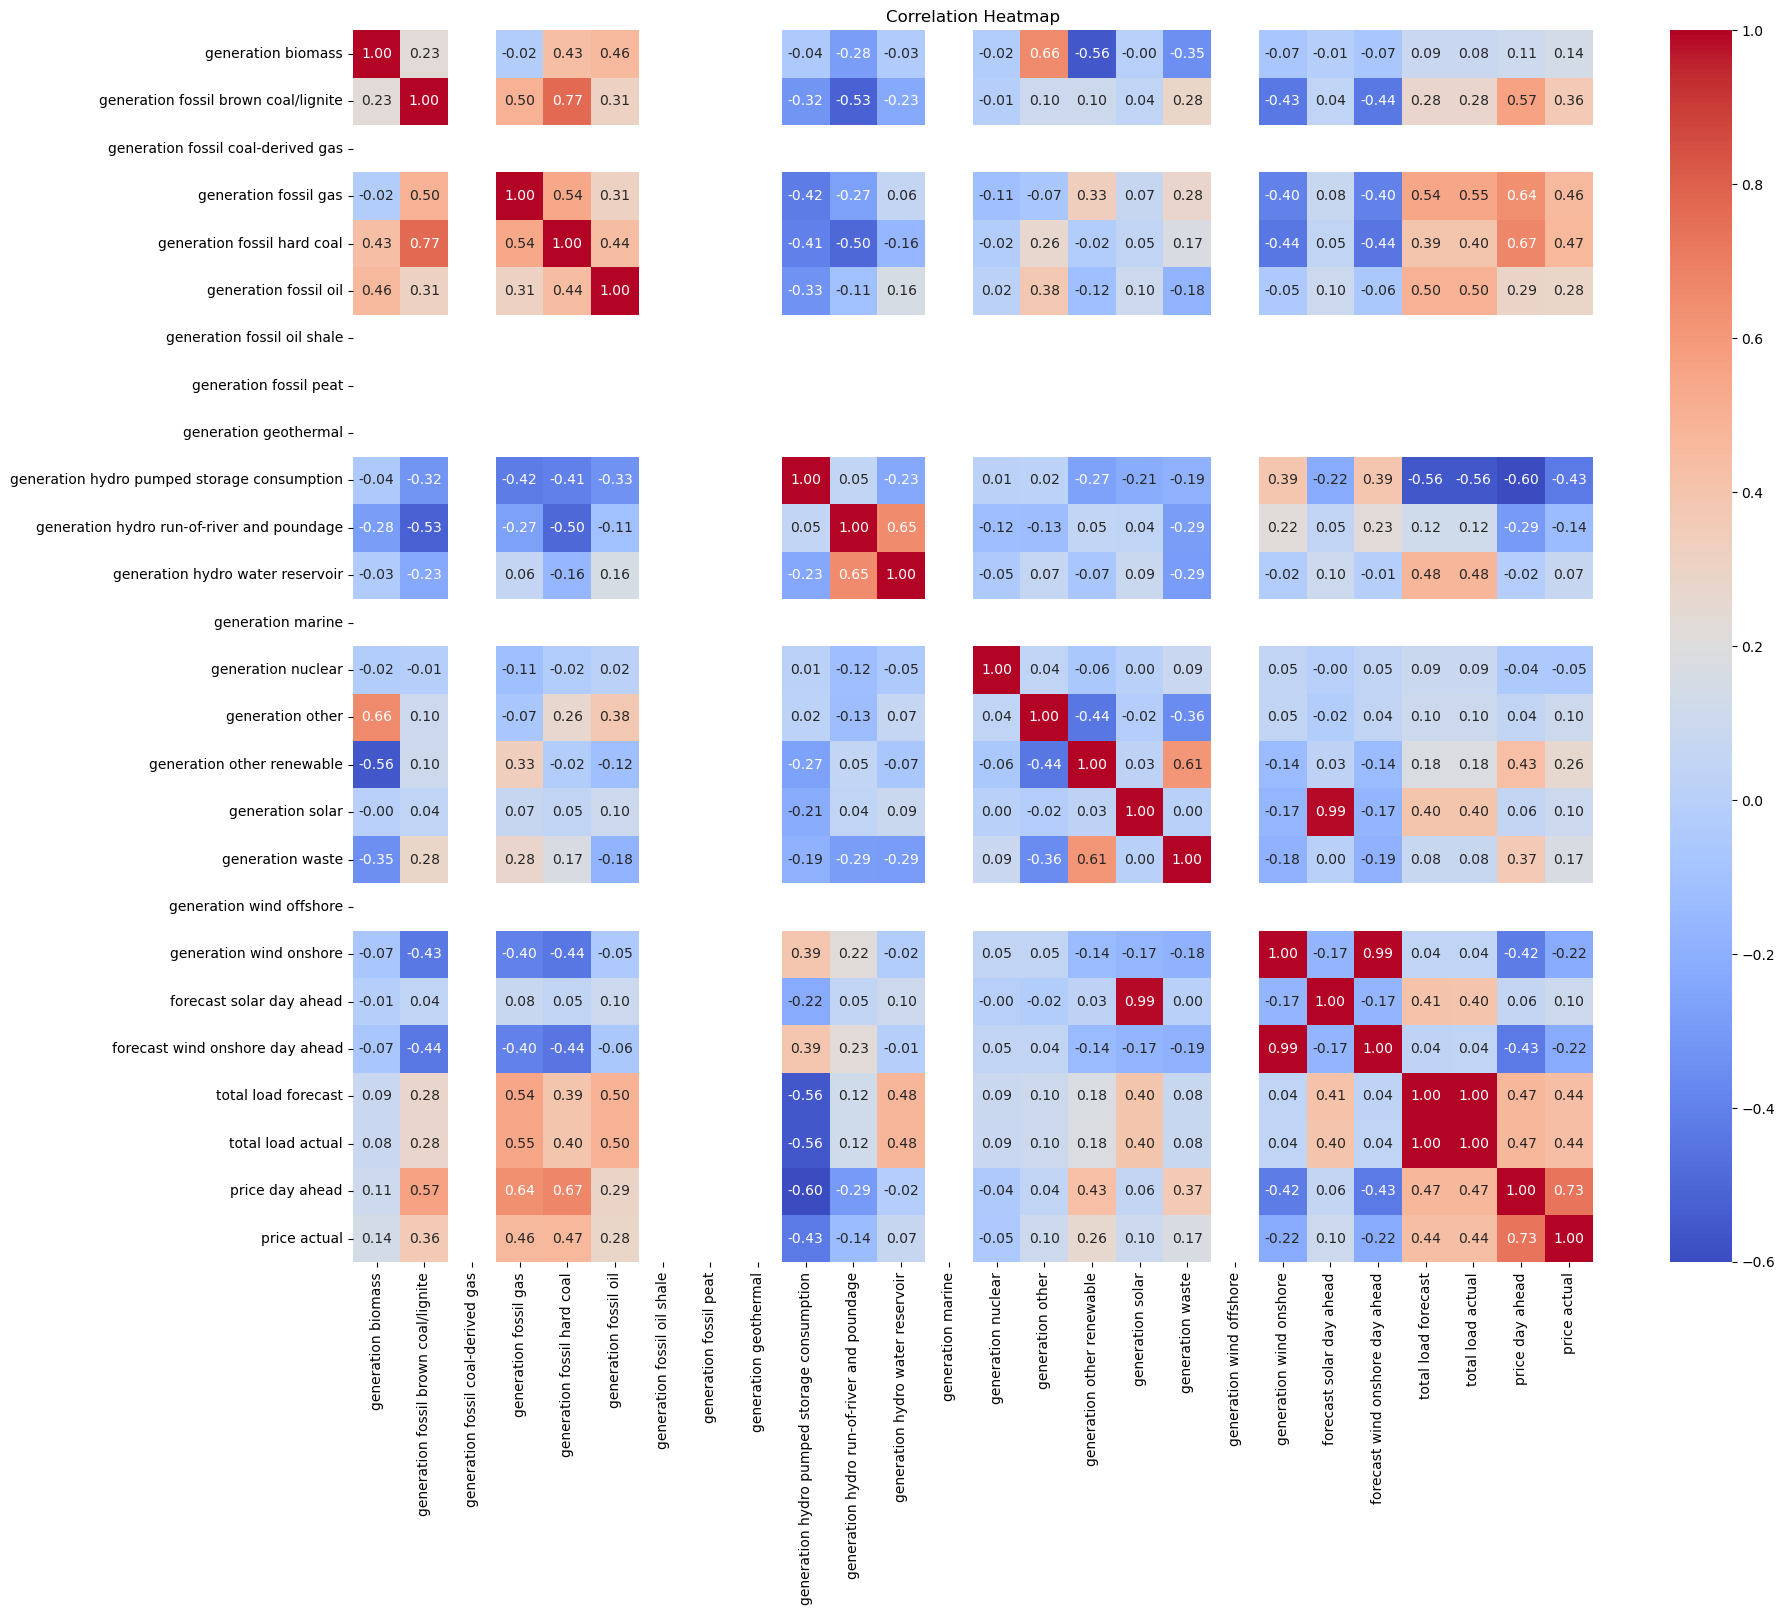

In [9]:
energy_corr = df_energy.drop(columns=['time'])
corr_energy = energy_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

We decided to drop features that have not correlation with any of other features, so they useless for our analysis.
1. 'generation fossil coal-derived gas'
2. 'generation fossil oil shale', 
3. 'generation fossil peat', 
4. 'generation geothermal', 
6. 'generation marine', 
7. 'generation wind offshore', 

We decided to drop features that have collinearity with other features, so they useless for our analysis: because collinearity will reduce the accuracy of the estimates.
- 'forecast wind onshore day ahead'
- 'forecast solar day ahead',
- 'total load forecast'

In [10]:
forecast_load_data = df_energy['total load forecast']
forecast_price_data = df_energy['price day ahead']
df_energy=df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 
                          'generation marine', 'generation wind offshore', 'total load forecast', 'forecast solar day ahead',
                          'forecast wind onshore day ahead'], axis=1)

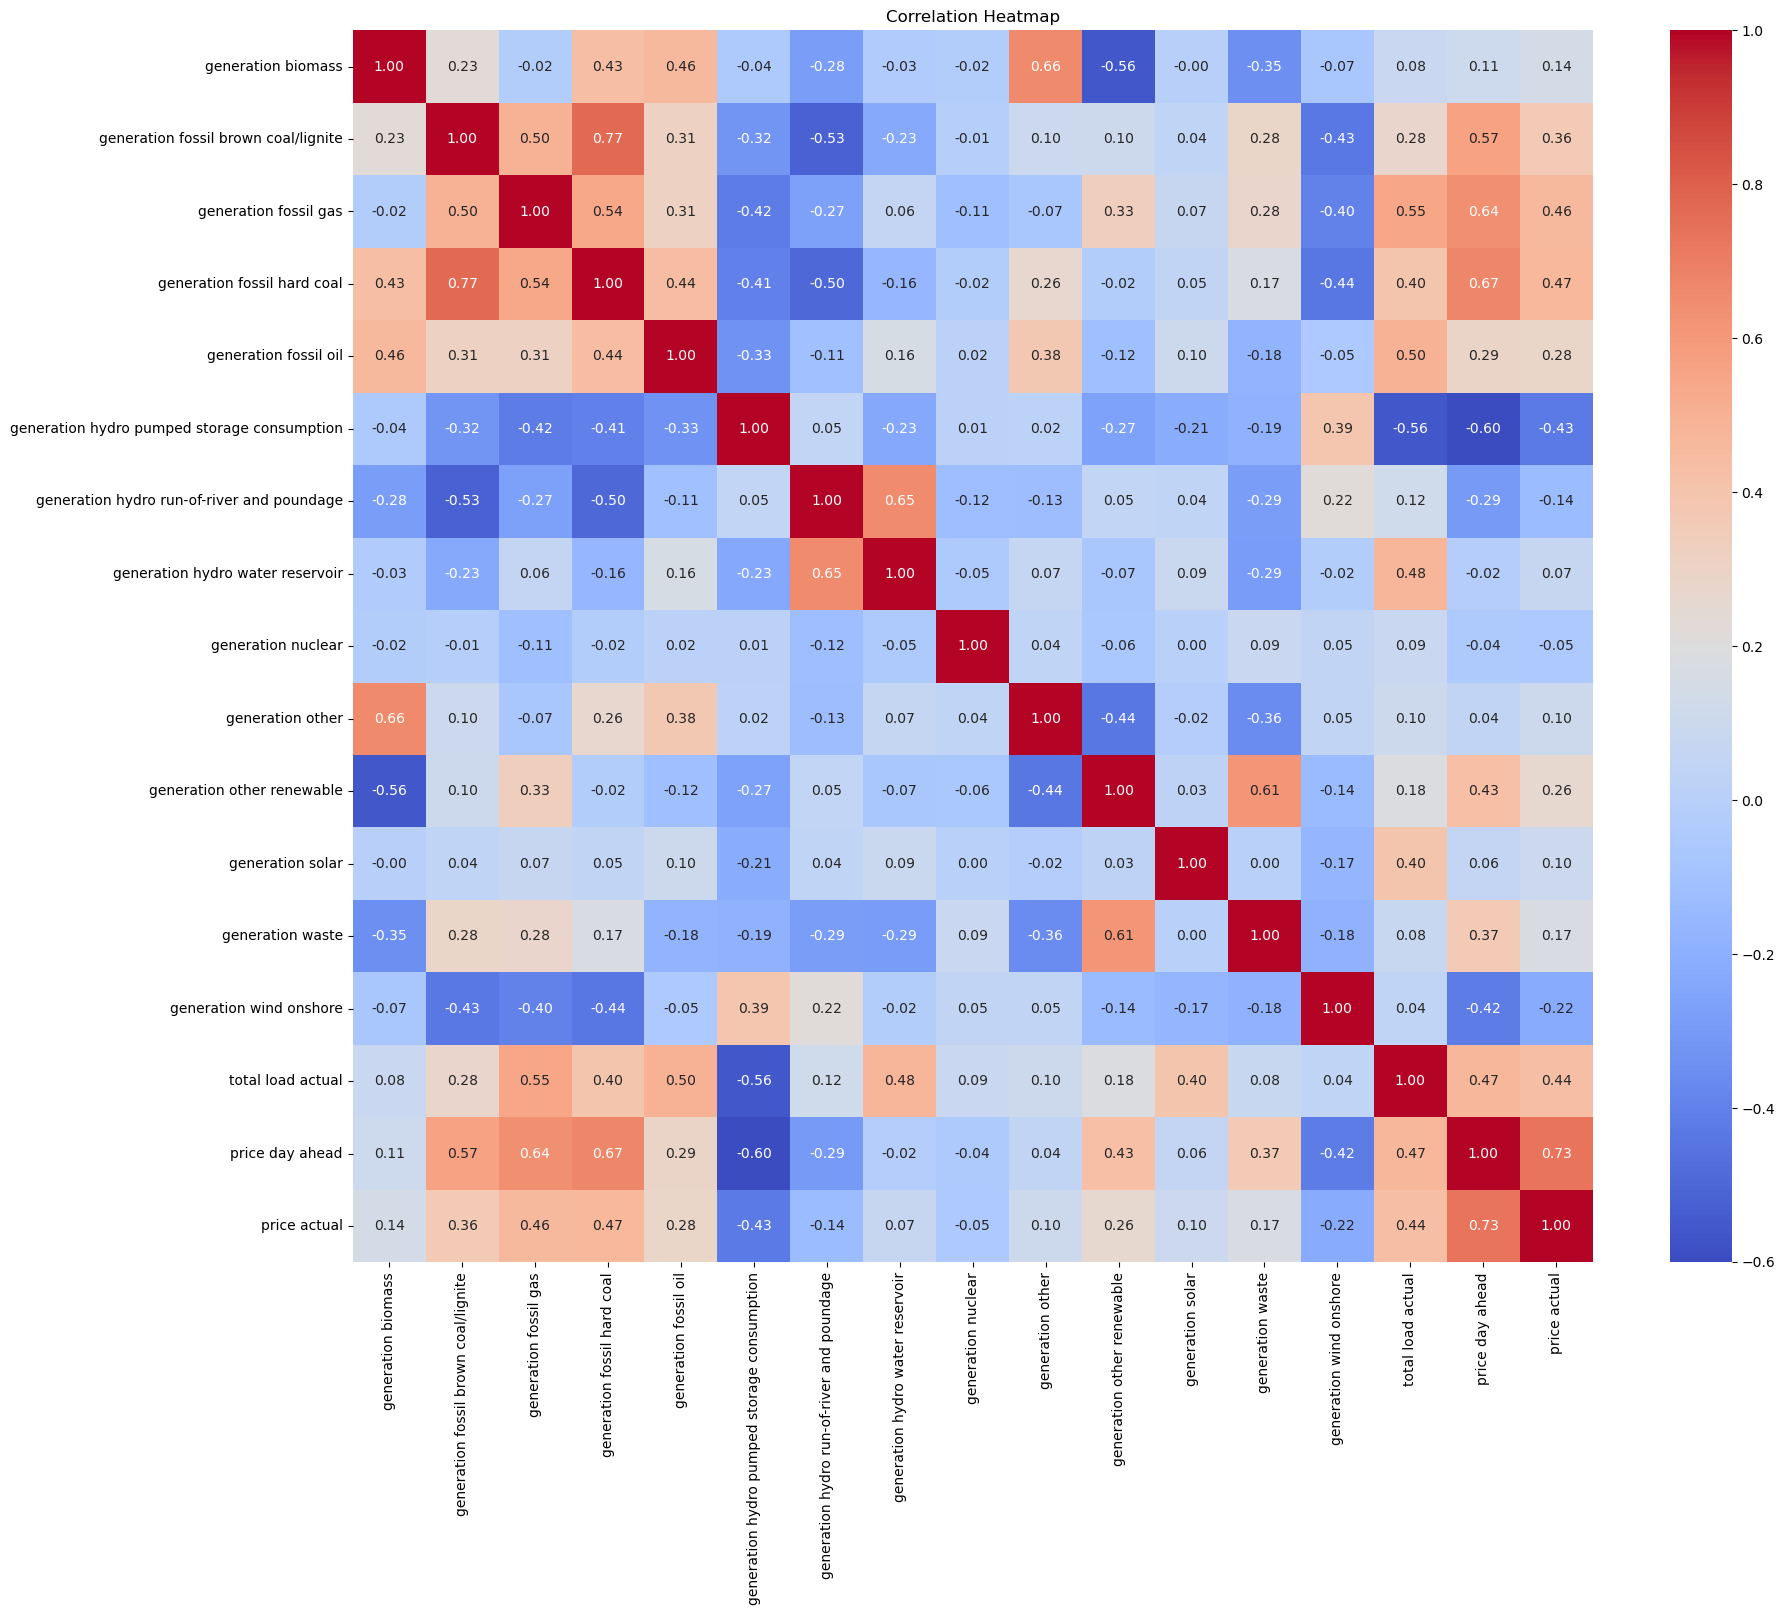

In [11]:
# The new correlation matrix

energy_corr = df_energy.drop(columns=['time'])
corr_energy = energy_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Check if there are missing values or duplicates in dataframe. 

In [12]:
print('There are {} missing values or NaNs in df_energy.'.format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


Impute missing values with interpolation

In [13]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## Weather dataset

In [14]:
df_weather.head(10)

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
5,2015-01-01 04:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
6,2015-01-01 05:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
7,2015-01-01 06:00:00+00:00,Valencia,270.292,270.292,270.292,1004,71,2,321,0.0,0.0,0.0,0,800,clear,sky is clear,01n
8,2015-01-01 07:00:00+00:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d
9,2015-01-01 08:00:00+00:00,Valencia,274.601,274.601,274.601,1005,71,1,307,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [15]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   time                 178396 non-null  datetime64[ns, UTC]
 1   city_name            178396 non-null  object             
 2   temp                 178396 non-null  float64            
 3   temp_min             178396 non-null  float64            
 4   temp_max             178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

In [16]:
df_weather["temp_Celsius"] = df_weather.temp - 273.15
df_weather["temp_min_Celsius"] = df_weather.temp_min - 273.15
df_weather["temp_max_Celsius"] = df_weather.temp_max - 273.15
df_weather.drop(columns = ['temp', 'temp_min', 'temp_max'], inplace = True)

In [17]:
new_column_order = ['city_name', 'time', 'temp_Celsius', 'temp_min_Celsius', 'temp_max_Celsius','pressure', 'humidity', 'wind_speed', 
                    'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h','clouds_all', 'weather_id', 'weather_main', 'weather_description','weather_icon']
df_weather = df_weather.reindex(columns = new_column_order)
df_weather

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,Valencia,2014-12-31 23:00:00+00:00,-2.675,-2.675,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,Valencia,2015-01-01 00:00:00+00:00,-2.675,-2.675,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,Valencia,2015-01-01 01:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,Valencia,2015-01-01 02:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,Valencia,2015-01-01 03:00:00+00:00,-3.464,-3.464,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,Seville,2018-12-31 18:00:00+00:00,14.610,14.000,15.000,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,Seville,2018-12-31 19:00:00+00:00,12.610,12.000,13.000,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,Seville,2018-12-31 20:00:00+00:00,12.000,12.000,12.000,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,Seville,2018-12-31 21:00:00+00:00,11.000,11.000,11.000,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [18]:
df_weather.describe().round(4)

,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.0000,178396.0000,178396.0000,1.783960e+05,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000,178396.0000
mean,16.4686,15.1804,17.9413,1.069261e+03,68.4235,2.4706,166.5912,0.0755,0.0004,0.0048,25.0733,759.8319
std,8.0262,7.9555,8.6125,5.969632e+03,21.9029,2.0959,116.6119,0.3988,0.0073,0.2226,30.7741,108.7332
min,-10.9100,-10.9100,-10.9100,0.000000e+00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,200.0000
25%,10.5200,9.3336,11.5000,1.013000e+03,53.0000,1.0000,55.0000,0.0000,0.0000,0.0000,0.0000,800.0000
50%,16.0000,15.0000,17.0000,1.018000e+03,72.0000,2.0000,177.0000,0.0000,0.0000,0.0000,20.0000,800.0000
75%,22.0000,20.5801,24.0000,1.022000e+03,87.0000,4.0000,270.0000,0.0000,0.0000,0.0000,40.0000,801.0000
max,42.4500,42.0000,48.0000,1.008371e+06,100.0000,133.0000,360.0000,12.0000,2.3150,21.5000,100.0000,804.0000


Here, we can see that all columns of df_weather have the same number of rows; we still have to check what is the case for each city individually, though. 
 The most important thing to notice is that there are some **problems** and **outliers**.

There are some problems with:
- The 'pressure' column
- The 'wind_speed' column
- The '3h_rain' column is supposed to provide information about the precipitation in the last 3 hours, for this reason it would be logical to assume that its mean would be higher of '1h_rain' column. But this is not the case, so it's a good idea to further examine those columns.

Here, we can see that all columns of `df_weather` have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. The most important thing to notice is that there are some **problems** and **outliers**. In particular:
- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [[2]](#ref5). This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [[3]](#ref6), a F5 (the largest intensity of the Fujita scale) tornado [[4]](#ref7). A tornado of such intensity has not been recorded in Spain [[5]](#ref9) and hopefully will not happen in the future as well. 
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.

In [19]:
mean_weather_without_time = df_weather.drop(columns = ['time', 'weather_description', 'weather_main', 'weather_icon'])
mean_weather_by_city = mean_weather_without_time.groupby('city_name').mean()
mean_weather_by_city

,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,16.698248,15.444704,17.871987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,13.228489,11.766661,14.886687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,14.911071,13.674877,16.005600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,19.955431,18.034103,22.812431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,17.630780,17.072277,18.205025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [20]:
# Disply the row for each city in df_weather

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

city_unique = df_weather.city_name.unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia
There are 36267 observations in df_weather about city: Madrid
There are 35951 observations in df_weather about city: Bilbao
There are 35476 observations in df_weather about city:  Barcelona
There are 35557 observations in df_weather about city: Seville


In [21]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather2 = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='first')

In [22]:
# Display the number of rows for each city again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in city_unique:
    print('There are', format(grouped_weather.get_group('{}'.format(city)).shape[0]),'observations in df_weather about city:', city)

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia
There are 35064 observations in df_weather about city: Madrid
There are 35064 observations in df_weather about city: Bilbao
There are 35064 observations in df_weather about city:  Barcelona
There are 35064 observations in df_weather about city: Seville


### Categorical features

The column 'weather_icon' is irrelevant for our analysis, so we will drop it. Furthermore, the columns 'weather_main' and 'weather_description' contain approximately the same information as the column 'weather_id'; the information concerns a qualitative description of the weather at the given hour. So, we will work with only one of them. However, in order to make a choice, we have to check the **unique values** as well as the **consistency** of each column. 

In [23]:
weather_description_unique = df_weather.weather_description.unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [24]:
weather_main_unique = df_weather.weather_main.unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [25]:
weather_id_unique = df_weather.weather_id.unique()
weather_id_unique

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 211, 520, 300, 201, 741, 711, 301, 302, 721, 600, 616, 615,
       601, 611, 311, 310, 620, 531, 602, 731, 761, 210, 771])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, `df_weather` and `df_weather_2`. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [26]:
# Define a function which will calculate R-squared score for the same column in our two datasets

def encode_and_display_r2_score(dataset1, dataset2, column, categorical = False):
    datasets = [dataset1, dataset2]
    if categorical:
        for df in datasets:
            label_encoder = LabelEncoder()
            df.loc[:, column] = label_encoder.fit_transform(df[column])
    r2 = r2_score(dataset1[column], dataset2[column])
    print("R-Squared score of", column, "is", r2)

In [27]:
encode_and_display_r2_score(df_weather, df_weather2, 'weather_description', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_main', categorical = True)
encode_and_display_r2_score(df_weather, df_weather2, 'weather_id')

R-Squared score of weather_description is 0.972978840026219
R-Squared score of weather_main is 0.9627152451498913
R-Squared score of weather_id is 0.9205784928822044


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in `df_weather`. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that **the R² values of these two are not comparable** because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the *Levenshtein distance*, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [28]:
# Drop columns with qualitative weather information

df_weather = df_weather.drop(['weather_main', 'weather_id', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset **is not 100% accurate**. This is because it compares two dataframes from which we have cleaned the duplicates in **only two ways exclusively**; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

## Outliers

In [29]:
# Function for the plot of the outlier

def visualize_outlier(df, city, var, date1 = '2014-12-31 23:00:00+00:00', date2 = '2018-12-31 22:00:00+00:00', date3 = False, date4 = False):
    df_weather_city = df[df['city_name'] == city]
    if date3 == False:
        time_mask = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
    
        plot_mask = df_weather_city[time_mask]
        
        plt.figure(figsize=(15, 7))
        plt.plot(plot_mask['time'].values, plot_mask[var].values, label = city)
        plt.xlabel('Date')
        plt.ylabel(var)

        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        time_mask1 = (df_weather_city['time'] > date1) & (df_weather_city['time'] < date2)
        time_mask2 = (df_weather_city['time'] > date3) & (df_weather_city['time'] < date4)
        
        plot_mask1 = df_weather_city[time_mask1]
        plot_mask2 = df_weather_city[time_mask2]
    
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        axs[0].plot(plot_mask1['time'].values, plot_mask1[var].values, label = city)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel(var)
        axs[0].tick_params(axis='x', rotation=90)

        axs[1].plot(plot_mask2['time'].values, plot_mask2[var].values, label = city)
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel(var)
        axs[1].tick_params(axis='x', rotation=90)

### Pressure outliers

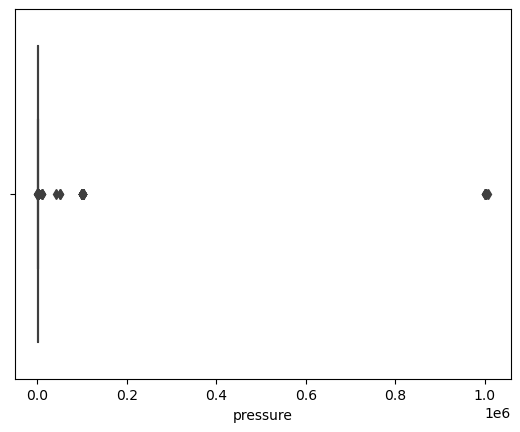

In [30]:
# Check for outliers in 'pressure' column

sns.boxplot(x = df_weather['pressure'])
plt.show()

In [31]:
pressure_mask = df_weather.pressure > 800000
df_weather[pressure_mask]

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_description
108589,Barcelona,2015-02-21 01:00:00+00:00,10.10,10.10,10.10,1008371,0,3,337,12.0,0.0,0.0,12,40
108596,Barcelona,2015-02-21 08:00:00+00:00,10.90,10.90,10.90,1001781,0,9,292,0.0,0.0,0.0,92,20
108597,Barcelona,2015-02-21 09:00:00+00:00,10.90,10.90,10.90,1001501,0,2,337,0.0,0.0,0.0,92,20
108598,Barcelona,2015-02-21 10:00:00+00:00,1.50,1.50,1.50,1000951,0,2,337,0.3,0.0,0.0,92,13
108618,Barcelona,2015-02-22 06:00:00+00:00,6.72,6.72,6.72,1002241,0,0,0,0.0,0.0,0.0,0,31
108619,Barcelona,2015-02-22 07:00:00+00:00,8.60,8.60,8.60,1002881,0,1,22,0.0,0.0,0.0,0,31


In [32]:
city_p = ' Barcelona'
var_p = 'pressure'
date1_p = '2015-02-15 01:00:00+00:00'
date2_p = '2015-02-28 01:00:00+00:00'

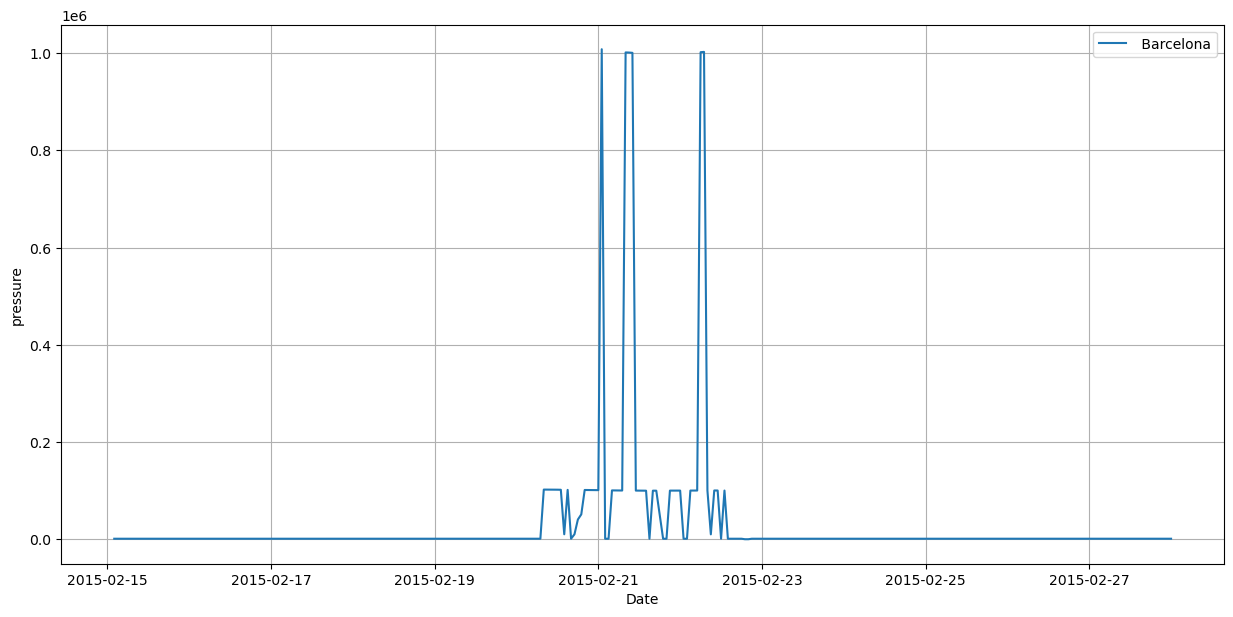

In [33]:
visualize_outlier(df_weather, city_p, var_p, date1_p, date2_p)

In [34]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

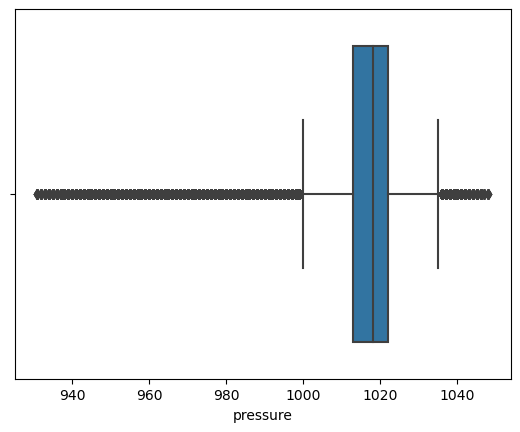

In [35]:
# Check again for outliers in 'pressure' column

sns.boxplot(x = df_weather['pressure'])
plt.show()

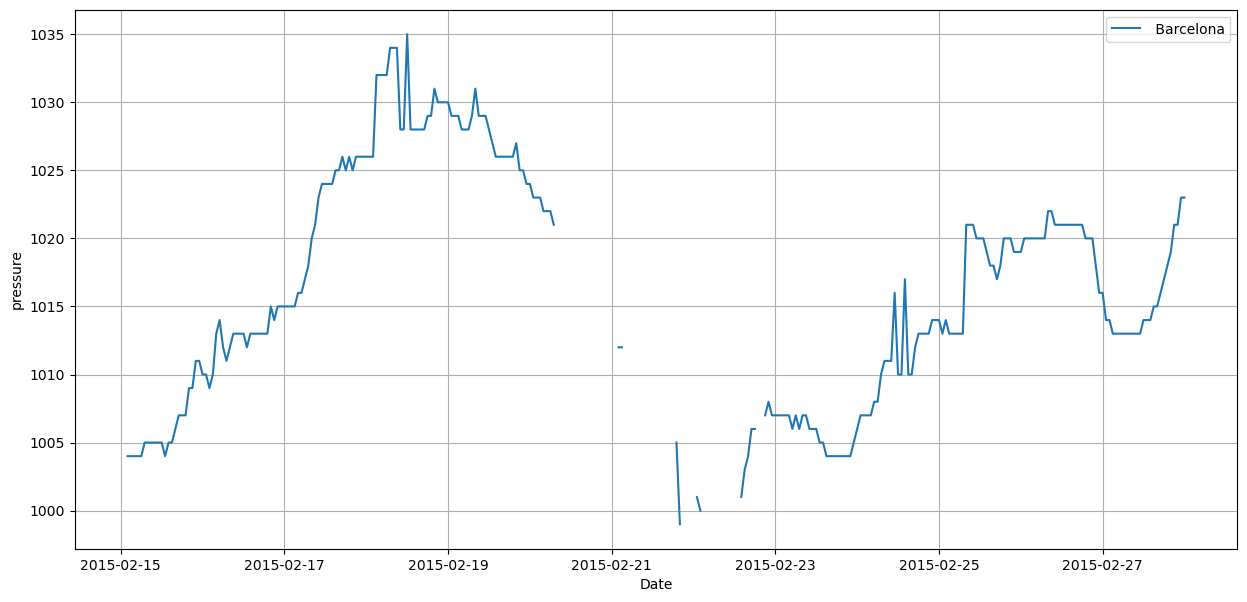

In [36]:
city = ' Barcelona'
var = 'pressure'
date1 = '2015-02-15 01:00:00+00:00'
date2 = '2015-02-28 01:00:00+00:00'

visualize_outlier(df_weather, city, var, date1, date2)

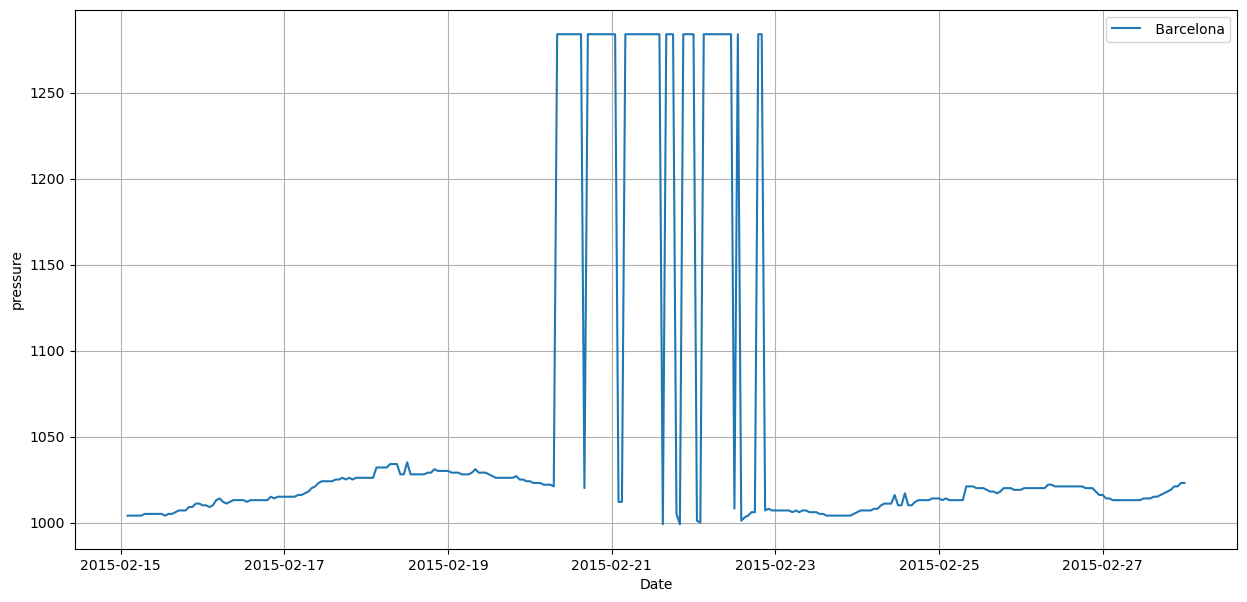

In [37]:
barcelona_pressure = mean_weather_by_city.loc[' Barcelona', 'pressure']
df_weather_pressure_mean = df_weather.fillna(barcelona_pressure)

visualize_outlier(df_weather_pressure_mean, city_p, var_p, date1_p, date2_p)

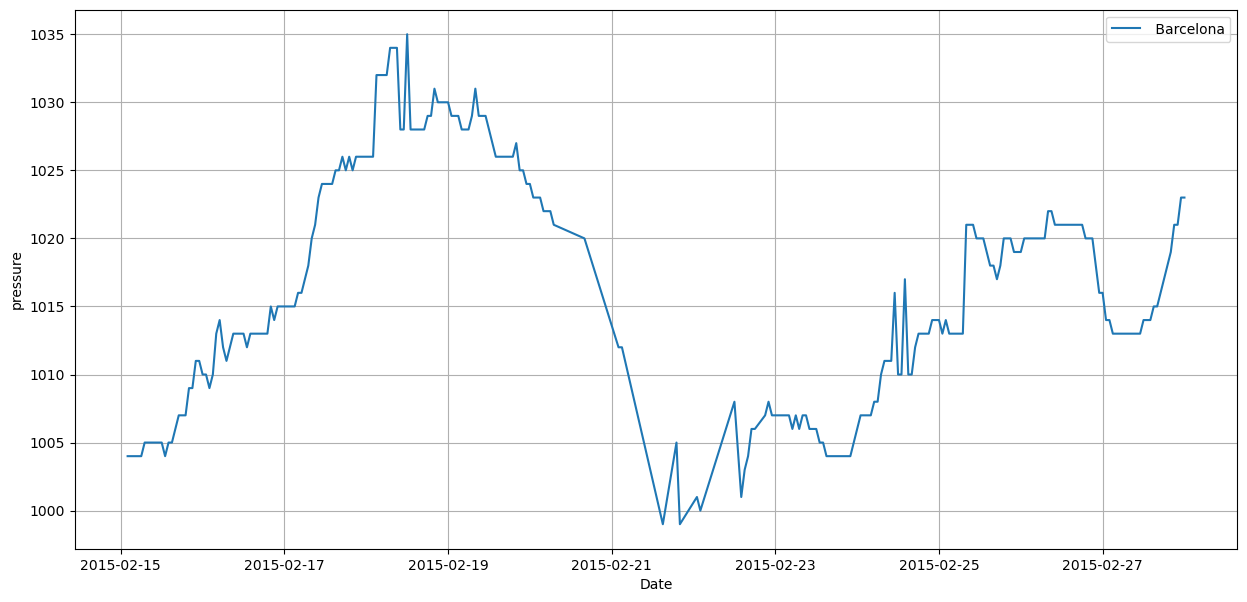

In [38]:
df_weather3 = df_weather.copy()
df_weather3.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

visualize_outlier(df_weather3, city_p, var_p, date1_p, date2_p)

### Wind_speed outliers

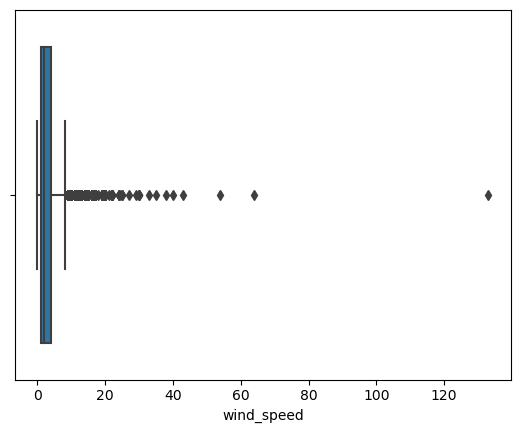

In [39]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x = df_weather['wind_speed'])
plt.show()

In [40]:
wind_mask = df_weather.wind_speed > 50
df_weather[wind_mask]

,city_name,time,temp_Celsius,temp_min_Celsius,temp_max_Celsius,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_description
708,Valencia,2015-01-30 10:00:00+00:00,16.6,16.6,16.6,997.0,62,64,314,0.0,0.0,0.0,0,31
712,Valencia,2015-01-30 14:00:00+00:00,17.8,17.8,17.8,993.0,58,54,262,0.0,0.0,0.0,0,31
20725,Valencia,2017-05-11 10:00:00+00:00,20.0,20.0,20.0,1002.0,52,133,20,0.0,0.0,0.0,20,3


In [41]:
city_w = 'Valencia'
var_w = 'wind_speed'
date1_w = '2015-01-29 10:00:00+00:00'
date2_w = '2015-01-31 10:00:00+00:00'
date3_w = '2017-05-10 10:00:00+00:00'
date4_w = '2017-05-12 10:00:00+00:00'

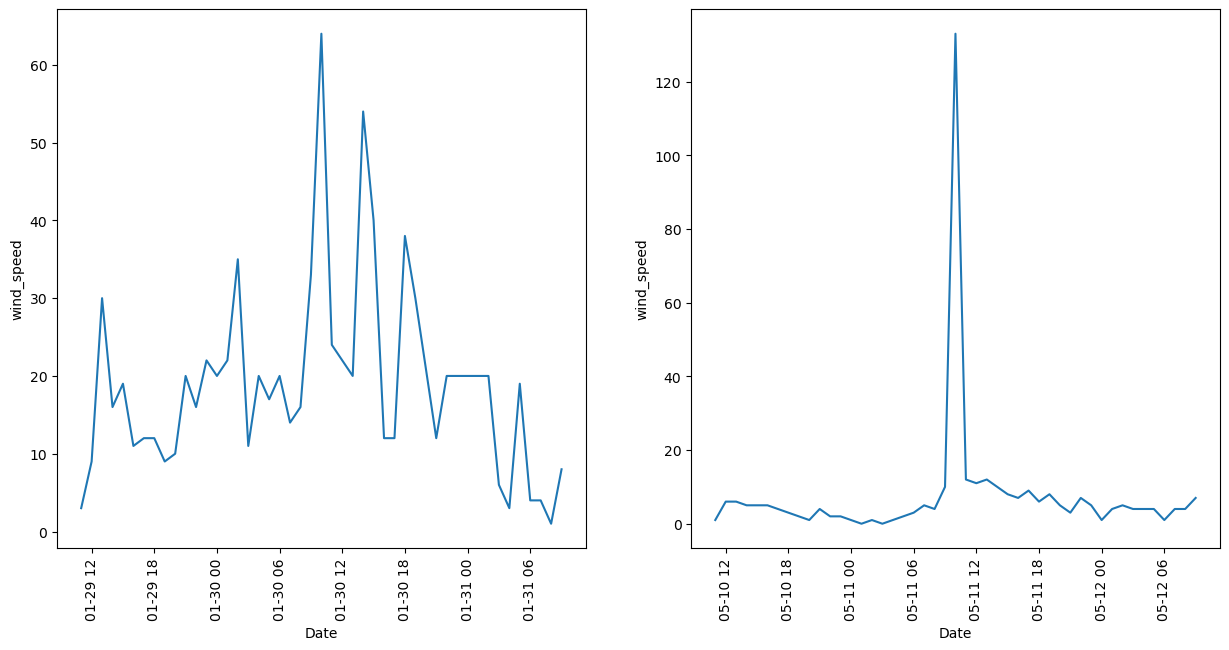

In [42]:
# Plot of the strange value in the wind_speed

visualize_outlier(df_weather, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

In [43]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

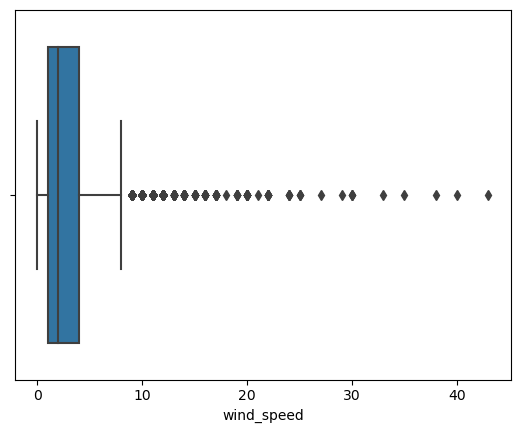

In [44]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

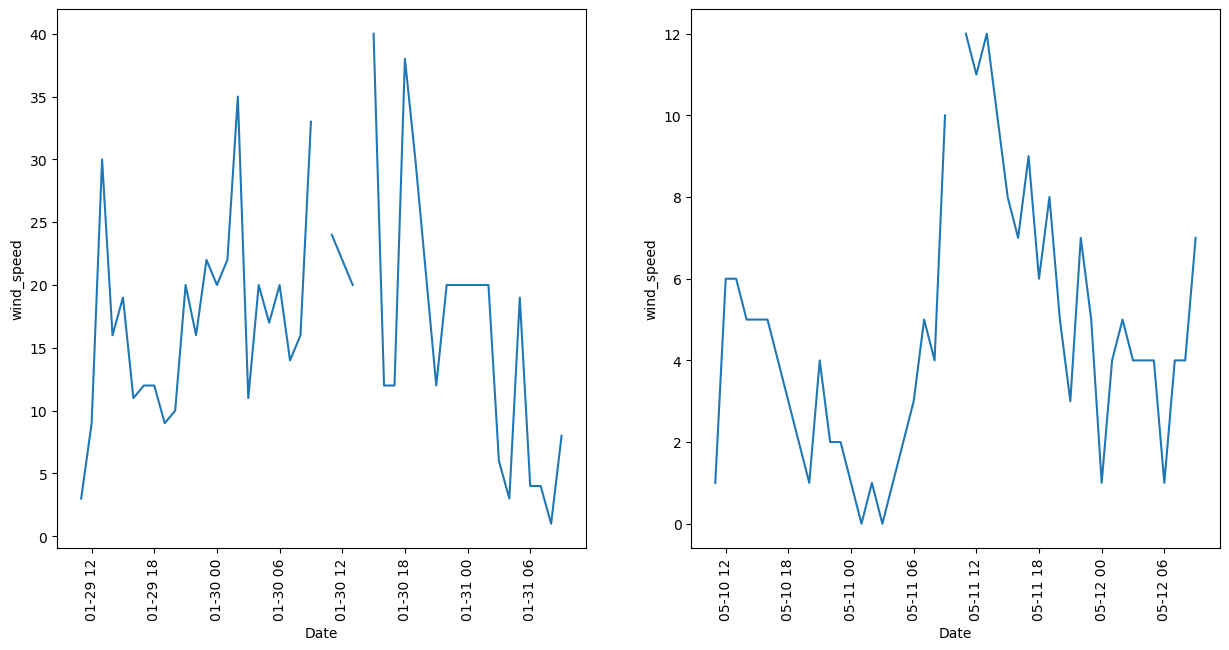

In [45]:
visualize_outlier(df_weather, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

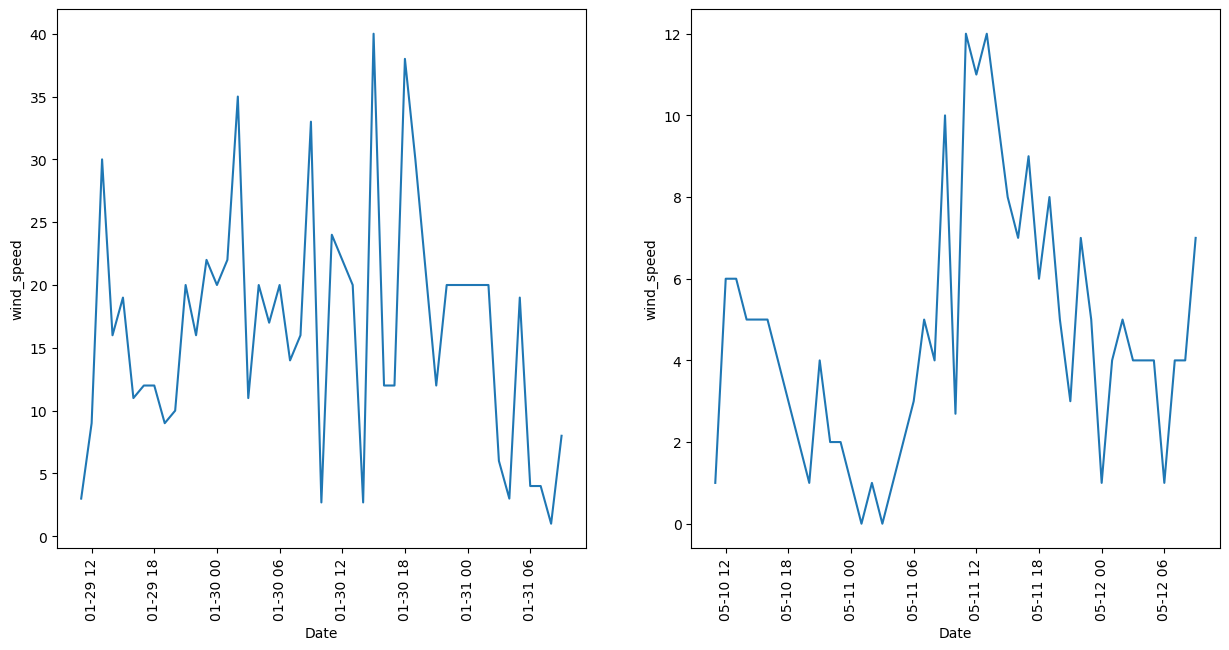

In [46]:
valencia_wind = mean_weather_by_city.loc['Valencia', 'wind_speed']
df_weather_wind_mean = df_weather.fillna(valencia_wind)

visualize_outlier(df_weather_wind_mean, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

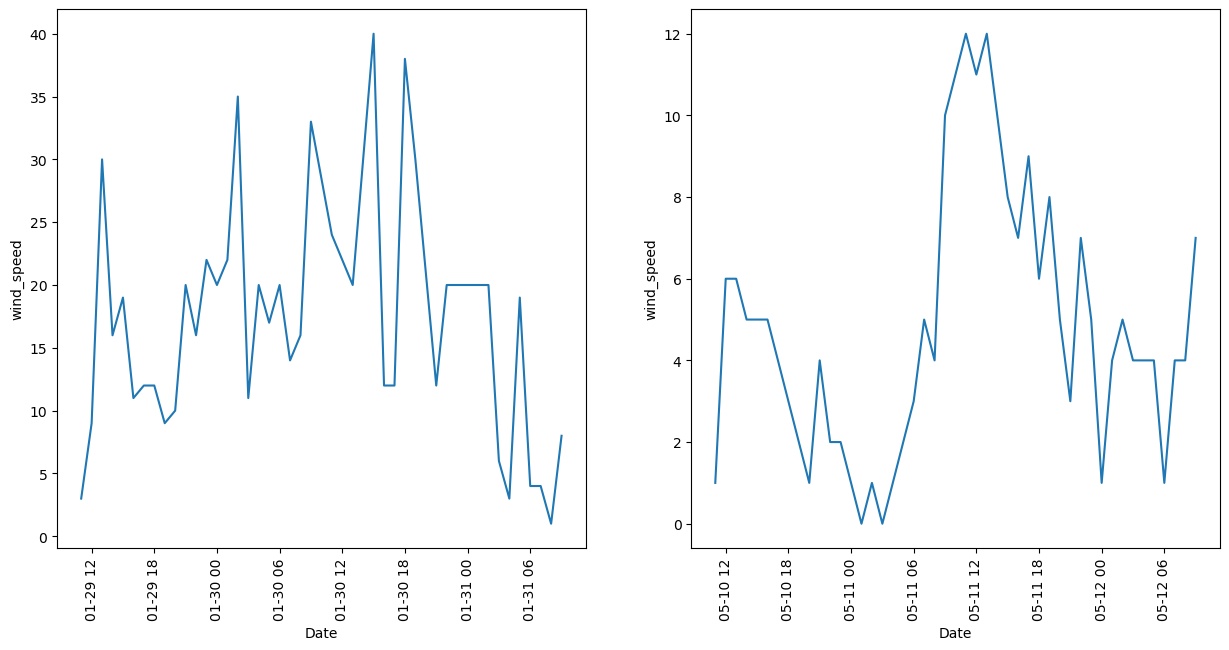

In [47]:
df_weather4 = df_weather.copy()
df_weather4.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

visualize_outlier(df_weather4, city_w, var_w, date1_w, date2_w, date3_w, date4_w)

In [48]:
df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## Check the '3h_rain' columns

In [49]:
def plot_total(cities):
    fig, axs = plt.subplots(2, len(cities), figsize=(5 * len(cities), 10), sharex=True)
    for i, city in enumerate(cities):
        city_data = df_weather[df_weather['city_name'] == city]
        axs[0, i].plot(city_data['time'], city_data['rain_1h'])
        axs[0, i].set_title(f'Rainfall for 1h in {city}')
        axs[0, i].set_xlabel('Date')
        axs[0, i].set_ylabel('mm')
        axs[0, i].tick_params(axis='x', rotation=45)
    for i, city in enumerate(cities):
        city_data = df_weather[df_weather['city_name'] == city]
        axs[1, i].plot(city_data['time'], city_data['rain_3h'])
        axs[1, i].set_title(f'Rainfall for 3h in {city}')
        axs[1, i].set_xlabel('Date')
        axs[1, i].set_ylabel('mm')
        axs[1, i].tick_params(axis='x', rotation=45)
    plt.show()  

In [50]:
# city_unique = df_weather['city_name'].unique()
# plot_total(city_unique)

In [51]:
def plot_total_3h(cities):
    fig, axs = plt.subplots(1, len(cities), figsize=(5 * len(cities), 10), sharex=False)
    for i, city in enumerate(cities):
        # Example selected city
        df_rain3h = df_weather[df_weather['city_name'] == city]

        # Check if the previous 3 rows had values higher than 0
        condition = (df_rain3h['rain_1h'].shift(1) > 0) & (df_rain3h['rain_1h'].shift(2) > 0) & (df_rain3h['rain_1h'].shift(3) > 0)

        # Filter rows based on the condition
        result = df_rain3h['rain_3h'][condition]
        
        # Plotting the result
        axs[i].plot(result.index, result.values, marker='o', linestyle='-', label='Rain 3h (Condition Met)')
        axs[i].set_title(f'{city}')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('mm')
        axs[i].tick_params(axis='x', rotation=45)

        # Set x-axis range based on the result index
        if not result.empty:
            axs[i].set_xlim([result.index.min(), result.index.max()])

    fig.suptitle('Rain 3h Values Across Multiple Cities Where Previous 3 Rain 1h Values > 0', fontsize=16)
    
    plt.show()

In [52]:
# city_unique = df_weather['city_name'].unique()
# plot_total_3h(city_unique)

From the two figures aboce, we can conclude that **'rain_3h' is an unreliable feature which will drop from the dataset**.

In [53]:
df_weather.drop(columns = ['rain_3h'], inplace = True)

## Prepare the dataset for the merged

In [54]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [55]:
# Merge all dataframes into the final dataframe

df_energy_weather = df_energy

for df in dfs:
    column_to_exclude = 'time'
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df_excluding_column = df.drop(columns=[column_to_exclude])
    df_with_suffix = df_excluding_column.add_suffix('_{}'.format(city_str))
    df_with_suffix[column_to_exclude] = df[column_to_exclude]
    df_energy_weather = df_energy_weather.merge(df_with_suffix, on = 'time')
    df_energy_weather = df_energy_weather.drop('city_name_{}'.format(city_str), axis=1)
    
df_energy_weather.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Celsius_Barcelona',
       'temp_min_Celsius_Barcelona', 'temp_max_Celsius_Barcelona',
       'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
       'wind_deg_Barcelona', 'rain_1h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'weather_description_Barcelona',
       'temp_Celsius_Bilbao', 'temp_min_Celsius_Bilbao',
       'temp_max_Celsius_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg

## OUTLIERS PLOTTED TOGETHER

In [56]:
# Ensure 'weather_main' is treated as a categorical variable
#df_energy_weather['weather_main'] = df_energy_weather['weather_main'].astype('category')

# Create the box plot
#plt.figure(figsize=(15, 10))
#df_energy_weather.boxplot(column='price actual', by='weather_main', grid=False)
#plt.title('Box Plot of Price Actual by Weather Condition')
#plt.suptitle('')  # Remove the default title to keep it clean
#plt.xlabel('Weather Condition')
#plt.ylabel('Price Actual')
#plt.xticks(rotation=90)
#plt.show()

# Requests
1. Visualize the load (*the total electricity demand over time*) and marginal supply curves.
2. What weather measurements, and cities influence most the electrical demand, prices generation capacity.
3. Can we forecast 24 hours in advance better than the TSO?
4. Can we predict electrical price by time of day better than TSO? 

## Request 1: Visualize the load (*the total electricity demand over time*) and marginal supply curves.

In [57]:
# # Plot total load actual over time
# plt.figure(figsize=(14, 7))

# # Calculate the 5-point moving average of 'total load actual'
# df_energy['total load actual 5 MA'] = df_energy['total load actual'].rolling(window=24*7).mean()

# plt.plot(df_energy['time'], df_energy['total load actual'], label='Total Load Actual')
# plt.plot(df_energy['time'], df_energy['total load actual 5 MA'], label='5-Point Moving Average', linestyle='--')
# #plt.plot(df_energy_weather['time'], df_energy_weather['total load forecast'], label='Total Load Actual')
# plt.xlabel('Time')
# plt.ylabel('Total Load (MW)')
# plt.title('Load Curve')
# plt.legend()
# plt.show()


<Figure size 2000x1600 with 0 Axes>

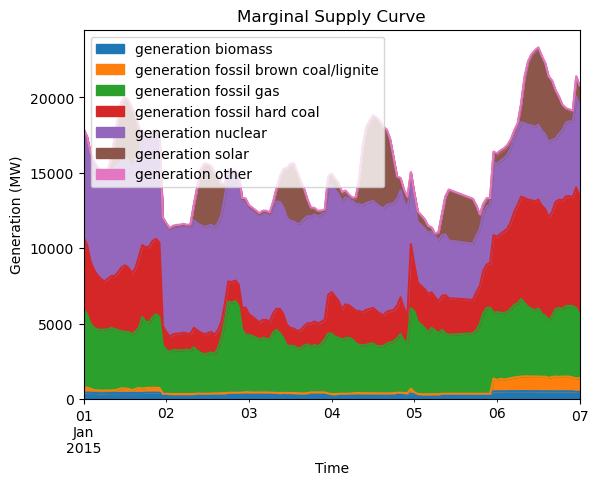

In [58]:
# List of generation columns
generation_columns = ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 
                      'generation nuclear', 'generation solar', 'generation other']

# Define the time window
start_date = '2015-01-01'
end_date = '2015-01-7'

# Filter the dataframe for the specified time window
mask = (df_energy_weather['time'] >= start_date) & (df_energy_weather['time'] <= end_date)
filtered_df = df_energy_weather.loc[mask]

plt.figure(figsize=(20, 16))
filtered_df.plot(kind='area', x='time', y=generation_columns, stacked=True)
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.title('Marginal Supply Curve')
plt.legend(loc='upper left')
plt.show()


## REQUEST 2: What weather measurements, and cities influence most the electrical demand, prices generation capacity.

We already explained in correlation part, so, it has to be delete. 

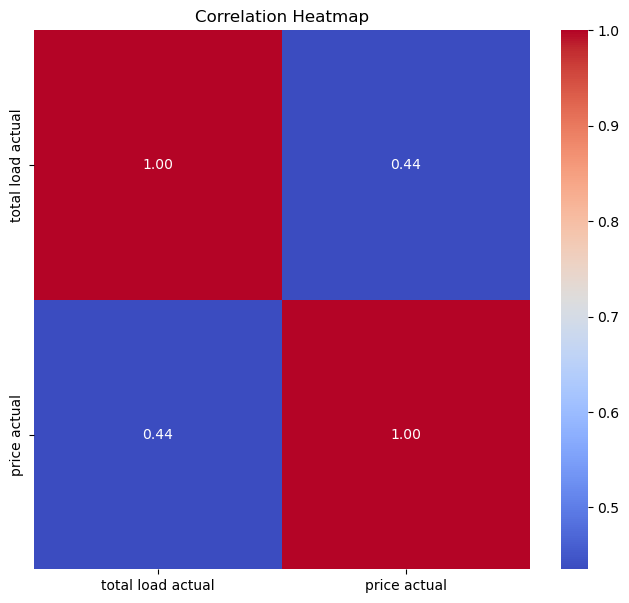

In [59]:
energy_corr = df_energy_weather.drop(columns=['time'])
# Select only columns that start with 'weather_main', 'city_name', 'total load actual', and 'price actual'
selected_columns = [col for col in energy_corr.columns if col.startswith('weather_main') or col.startswith('city_name') or col in ['rain_1h','rain_3h','snow_3h','clouds_all', 'total load actual', 'price actual']]
filtered_corr = energy_corr[selected_columns]

corr_energy = filtered_corr.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(corr_energy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# MODELS

We have tried different models. Explain them one by one later.

In [61]:
# Define target columns
target_columns = ['total load actual', 'price actual']

# List of numerical columns to be normalized, excluding the target columns
numerical_cols = [col for col in df_energy_weather.select_dtypes(include=['float64', 'int64']).columns if col not in target_columns]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
df_energy_weather[numerical_cols] = scaler.fit_transform(df_energy_weather[numerical_cols])

# Check the normalized features
#print(df_energy_weather.head())

## Building Model

The metrics of existing forecast for total load and price.

Here we had to make an critical assumption as in the dataset there is no info given on this topic.

The forecasted load and price data is not described clearly, it can be both the **forecast for the next 24 hours data** or it can be **forecasted value from 24 hours before**.

In our assumption we selected the case of forecasted value from 24 hours before and evaluated the forecasted values.

Below showed the TSO forecasts

In [62]:
def evaluate_forecast(actual, predicted):
    """
    Evaluate the performance of the forecast using various metrics.
    
    Parameters:
    - actual: Series or array-like, actual values
    - predicted: Series or array-like, predicted values
    
    Returns:
    - A dictionary containing MSE, MAE, RMSE, and R² score.
    """
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'R² Score': r2
    }


In [63]:

# Example usage with the dataset
# Assuming df_final is your DataFrame and it includes columns 'total load actual', 'total load forecast', 'price actual', 'price day ahead'
actual_total_load = df_energy_weather['total load actual']

actual_price = df_energy_weather['price actual']

# Evaluate total load forecast
total_load_evaluation = evaluate_forecast(actual_total_load, forecast_load_data)
print("Total Load Forecast Evaluation:", total_load_evaluation)

# Evaluate price forecast
price_evaluation = evaluate_forecast(actual_price, forecast_price_data)
print("Price Forecast Evaluation:", price_evaluation)

Total Load Forecast Evaluation: {'Mean Squared Error': 206707.52533436214, 'Mean Absolute Error': 316.8893309377139, 'Root Mean Squared Error': 454.6509928883496, 'R² Score': 0.9901274548489826}
Price Forecast Evaluation: {'Mean Squared Error': 175.55870664499204, 'Mean Absolute Error': 10.485264658909424, 'Root Mean Squared Error': 13.249856853754762, 'R² Score': 0.12982152162245753}


## Model Evaluation

In [64]:
def prepare_data(df, target, columns_to_exclude=[]):

    # Drop 'time' column if present
    if 'time' in df.columns:
        df = df.drop(columns=['time'])
    
    # Dynamically select features by excluding the columns we don't need
    features = [col for col in df.columns if col not in columns_to_exclude + [target]]
    
    X = df[features]
    y = df[target]
    
    return X, y

def train_model(X_train, y_train, model):
    
    model.fit(X_train, y_train)
    return model

def train_and_evaluate(df, target, model, columns_to_exclude=[]):

    X, y = prepare_data(df, target, columns_to_exclude)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model_train = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, model_train, target)

def evaluate_and_plot(X_test, y_test, model, target):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    MSE = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {MSE}')
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print(f'MAE score is: {MAE}')
    RMSE = np.sqrt(MSE)
    print(f'RMSE score is: {RMSE}')
    R2_Score = metrics.r2_score(y_test, y_pred)
    print(f'R2_Score score is: {R2_Score}')
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.xlabel('Sample')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.legend()
    plt.show()



Shift the target columns by 24 hours to create new targets for forecasting 24 hours ahead


In [67]:
# Shift the target columns by 24 hours to create new targets for forecasting 24 hours ahead
df_energy_weather['total_load_actual_24h_ahead'] = df_energy_weather['total load actual'].shift(-24)
df_energy_weather['price_actual_24h_ahead'] = df_energy_weather['price actual'].shift(-24)

# Drop rows with NaN values created by the shift
df_energy_weather = df_energy_weather.dropna(subset=['total_load_actual_24h_ahead', 'price_actual_24h_ahead'])


load_actual_24h_data = df_energy_weather['total_load_actual_24h_ahead'].values
price_actual_24h_data = df_energy_weather['price_actual_24h_ahead'].values


### Request 3 Can we forecast 24 hours in advance better than the TSO?

In [68]:
target = 'total_load_actual_24h_ahead'
df_energy_weather.drop('price_actual_24h_ahead',axis=1,inplace=True)

#### Linear Regression

Mean Squared Error: 8822140.116400942
MAE score is: 2274.3972913464663
RMSE score is: 2970.2087664675933
R2_Score score is: 0.5717187516222682


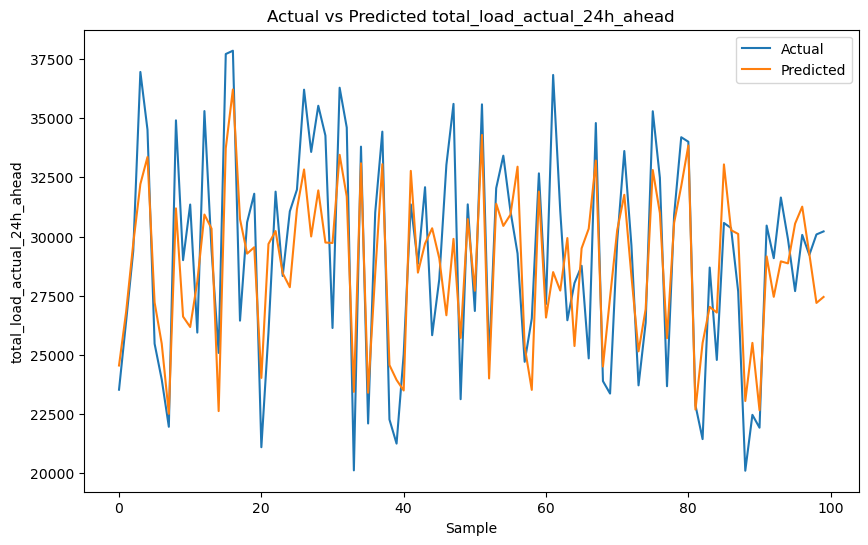

In [69]:
model = LinearRegression()

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

#### Polynomial

In [68]:
def train_and_evaluate_polynomial(X, y, model):
    """
    Full pipeline: Split data, train model, and evaluate with plotting.
    
    Parameters:
    - X: DataFrame, features
    - y: Series, target
    - model: an instantiated machine learning model
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    trained_model = train_model(X_train, y_train, model)
    
    evaluate_and_plot(X_test, y_test, trained_model, target)

Mean Squared Error: 14476303.059267035
MAE score is: 2011.2685296161796
RMSE score is: 3804.773719850766
R2_Score is: 0.29723070997351475


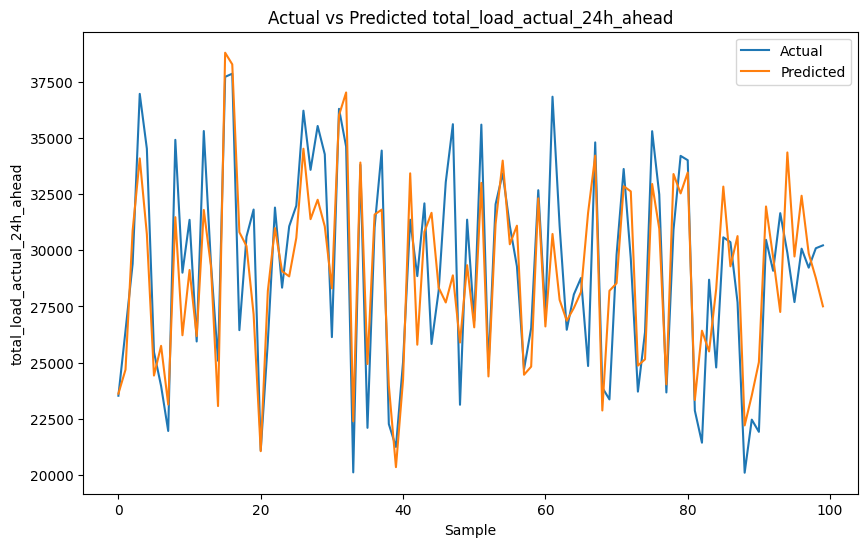

In [69]:

# Define the target variable and columns to exclude
target = 'total_load_actual_24h_ahead'

# Prepare the data
X, y = prepare_data(df_energy_weather, target)

# Apply Polynomial Features transformation
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate_polynomial(X_polynomial, y, model)


RAM issues for polynomial of degree 3 

In [ ]:
# degree = 3
# poly = PolynomialFeatures(degree=degree, include_bias=False)
# X_polynomial = poly.fit_transform(X)

# # Choose the model you want to use
# model = LinearRegression()  # Example model

# # Run the pipeline
# train_and_evaluate_polynomial(X_polynomial, y, model)

#### Gradient Boosting Regressor

Mean Squared Error: 7184856.998578662
MAE score is: 2023.4432545702502
RMSE score is: 2680.4583560612655
R2_Score score is: 0.6512026011640706


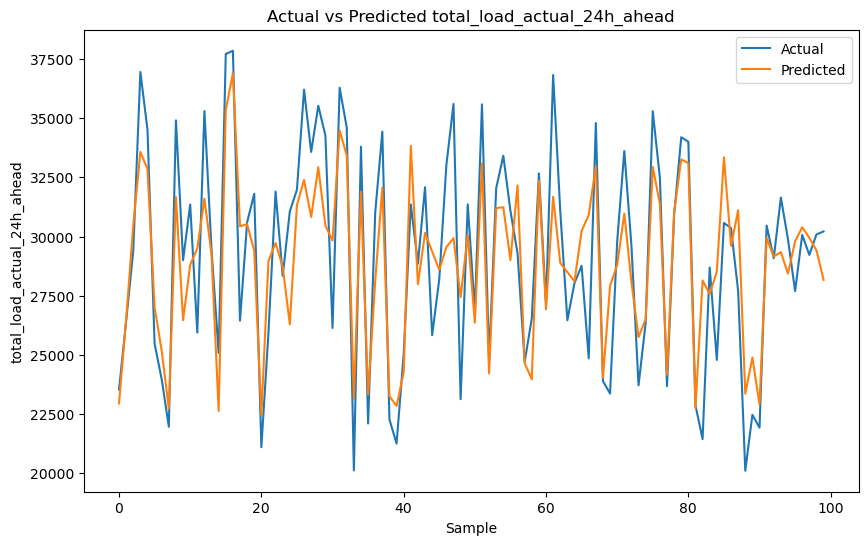

In [70]:
model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

#### Random Forest Regressor

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
    
# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

ADD  COMMENT ABOUT IF WE EPREDICT BETTER THAN TSO

### Request 4: Can we predict electrical price by time of day better than TSO? 

In [ ]:
# Define the target variable and columns to exclude
target = 'price_actual_24h_ahead'
df_energy_weather['price_actual_24h_ahead'] = price_actual_24h_data
df_energy_weather.drop('total_load_actual_24h_ahead',axis = 1,inplace = True)

Linear Regression

In [ ]:
model = LinearRegression()

# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

Polynomial

In [ ]:
# Define the target variable and columns to exclude
target = 'price_actual_24h_ahead'

# Prepare the data
X, y = prepare_data(df_1, target)

# Apply Polynomial Features transformation
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_polynomial = poly.fit_transform(X)

# Choose the model you want to use
model = LinearRegression()  # Example model

# Run the pipeline
train_and_evaluate_polynomial(X_polynomial, y, model)

Gradient Boosting Regressor

In [ ]:
model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
    
# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

Random Forest Regressor

In [ ]:
model = RandomForestRegressor(n_estimators = 100, random_state = 42)
    
# Run the pipeline
train_and_evaluate(df_energy_weather, target, model)

# Conclusions

### Total Load Forecast Evaluation

| Measure               | Existing Load Forecast | Gradient Boosting Regressor | Multi Linear Regression | Polynomial Regression | Random Forest Regressor |
|-----------------------|------------------------|-----------------------------|-------------------------|-----------------------|--------------------------|
| Mean Squared Error    | 206707.53              | 7195124.53                  | 8816955.64              | 6937680.61            | 4302377.92               |
| Mean Absolute Error   | 316.89                 | 2025.67                     | 2273.01                 | 1994.16               | 1498.12                  |
| Root Mean Squared Error | 454.65               | 2682.37                     | 2969.34                 | 2633.95               | 2074.22                  |
| R² Score              | 0.9901                 | 0.6507                      | 0.5720                  | 0.6632                | 0.7911                   |

### Price Forecast Evaluation

| Measure               | Existing Price Forecast | Gradient Boosting Regressor | Multi Linear Regression | Polynomial Regression | Random Forest Regressor |
|-----------------------|-------------------------|-----------------------------|-------------------------|-----------------------|--------------------------|
| Mean Squared Error    | 175.56                  | 50.57                       | 57.05                   | 49.12                 | 30.92                    |
| Mean Absolute Error   | 10.49                   | 5.19                        | 5.49                    | 5.03                  | 3.96                     |
| Root Mean Squared Error | 13.25                 | 7.11                        | 7.55                    | 7.01                  | 5.56                     |
| R² Score              | 0.1298                  | 0.7398                      | 0.7065                  | 0.7473                | 0.8410                   |

### Summary:

- **Mean Squared Error (MSE)**: The average of the squares of the errors. Lower values indicate better performance.
- **Mean Absolute Error (MAE)**: The average of the absolute errors. Lower values indicate better performance.
- **Root Mean Squared Error (RMSE)**: The square root of the average of the squares of the errors. Lower values indicate better performance.
- **R² Score**: The proportion of the variance in the dependent variable that is predictable from the independent variables. Higher values (closer to 1) indicate better performance. Negative values can occur if the model is worse than a horizontal line (mean of the target values).

From the tables, it is evident that the Random Forest Regressor generally performs better across both total load and price forecasts. The performance differences highlight the importance of model selection and the potential need for feature scaling and transformation.